In [ ]:
import pandas as pd

# Read the file
df = pd.read_csv('gs://labs.roitraining.com/data-to-ai-workshop/emergency_calls_response_times.csv')


# Pull the data schema and data types to determine the required table schema.
print(df.dtypes)

call_id                  int64
call_timestamp          object
call_type               object
location                object
weather_condition       object
day_of_week             object
time_of_day              int64
traffic_level           object
distance_to_station    float64
units_available          int64
response_time          float64
dtype: object


In [ ]:
from google.cloud import bigquery

# Define BQ schema, use BQ client library to create the table.
schema = [
    bigquery.SchemaField("call_id", "INTEGER"),
    bigquery.SchemaField("call_timestamp", "STRING"),
    bigquery.SchemaField("call_type", "STRING"),
    bigquery.SchemaField("location", "STRING"),
    bigquery.SchemaField("weather_condition", "STRING"),
    bigquery.SchemaField("day_of_week", "STRING"),
    bigquery.SchemaField("time_of_day", "INTEGER"),
    bigquery.SchemaField("traffic_level", "STRING"),
    bigquery.SchemaField("distance_to_station", "FLOAT"),
    bigquery.SchemaField("units_available", "INTEGER"),
    bigquery.SchemaField("response_time", "FLOAT"),
]
# Set dataset reference vars.
project_id = "qwiklabs-gcp-02-949c0486d822"
dataset_id = "dani_data_to_ai_workshop"
table_id = "emergency_calls_response_times"

client = bigquery.Client()
dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
dataset = bigquery.Dataset(dataset_ref)
client.create_dataset(dataset, exists_ok=True)

# Create the table if it doesn't exist.
table_ref = bigquery.TableReference(dataset_ref, table_id)
table = bigquery.Table(table_ref, schema=schema)
client.create_table(table, exists_ok=True)

# Load the data into the table.
job_config = bigquery.LoadJobConfig(
    schema=schema,
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,  # Skip the header row
)

job = client.load_table_from_uri(
    'gs://labs.roitraining.com/data-to-ai-workshop/emergency_calls_response_times.csv',
    table,
    location='US',
    job_config=job_config
)

try:
    job.result()  # Wait for the job to complete
    table = client.get_table(table_ref)
    print(f"Loaded {table.num_rows} rows and {len(table.schema)} columns to {table_id}")
except Exception as e:
    print(f"Error loading data: {e}")

Loaded 50000 rows and 11 columns to emergency_calls_response_times


In [ ]:
# Create a BigQuery ML model to predict response times
# use a linear regression model since we're predicting a continuous value (response_time)

create_model_query = f"""
CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.response_time_prediction_model`
OPTIONS(
  model_type='LINEAR_REG',
  input_label_cols=['response_time'],
  DATA_SPLIT_METHOD='AUTO_SPLIT'
) AS
SELECT
  call_type,
  location,
  weather_condition,
  day_of_week,
  time_of_day,
  traffic_level,
  distance_to_station,
  units_available,
  response_time
FROM
  `{project_id}.{dataset_id}.{table_id}`
"""

# Execute the query to create the model
job = client.query(create_model_query)
try:
    job.result()  # Wait for the job to complete
    print("Model created successfully!")
except Exception as e:
    print(f"Error creating model: {e}")


Model created successfully!


In [ ]:
# Evaluate the model performance
evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{project_id}.{dataset_id}.response_time_prediction_model`)
"""

# Run the evaluation query
eval_job = client.query(evaluate_query)
try:
    eval_results = eval_job.result()
    print("Model evaluation results:")
    for row in eval_results:
        print(f"Mean Absolute Error: {row.mean_absolute_error}")
        print(f"Mean Squared Error: {row.mean_squared_error}")
        print(f"R^2 Score: {row.r2_score}")
except Exception as e:
    print(f"Error evaluating model: {e}")


Model evaluation results:
Mean Absolute Error: 1.7619337069068535
Mean Squared Error: 4.827846250493765
R^2 Score: 0.8314167591183915


In [ ]:
# Make predictions with the model against synthetic data


# Create a synthetic data table
table_id = "emergency_calls_response_times_synthetic"
schema = [
    bigquery.SchemaField("call_type", "STRING"),
    bigquery.SchemaField("location", "STRING"),
    bigquery.SchemaField("weather_condition", "STRING"),
    bigquery.SchemaField("day_of_week", "STRING"),
    bigquery.SchemaField("time_of_day", "INTEGER"),
    bigquery.SchemaField("traffic_level", "STRING"),
    bigquery.SchemaField("distance_to_station", "FLOAT"),
    bigquery.SchemaField("units_available", "INTEGER"),
    bigquery.SchemaField("response_time", "FLOAT"),
]
table_ref = bigquery.TableReference(dataset_ref, table_id)
table = bigquery.Table(table_ref, schema=schema)
client.create_table(table, exists_ok=True)

# Read the original CSV to understand data distributions
import numpy as np
import random
from datetime import datetime, timedelta

# Read a sample of the original data to understand distributions
df_sample = pd.read_csv('gs://labs.roitraining.com/data-to-ai-workshop/emergency_calls_response_times.csv', nrows=5000)

# Extract unique values and distributions from the sample
call_types = df_sample['call_type'].unique().tolist()
locations = df_sample['location'].unique().tolist()
weather_conditions = df_sample['weather_condition'].unique().tolist()
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
traffic_levels = df_sample['traffic_level'].unique().tolist()

# Get statistical distributions for numerical fields
min_time_of_day = int(df_sample['time_of_day'].min())
max_time_of_day = int(df_sample['time_of_day'].max())
min_distance = float(df_sample['distance_to_station'].min())
max_distance = float(df_sample['distance_to_station'].max())
min_units = int(df_sample['units_available'].min())
max_units = int(df_sample['units_available'].max())

# Create response time model based on features (simplified)
mean_response_time = df_sample['response_time'].mean()
std_response_time = df_sample['response_time'].std()

# Generate 100 synthetic records
num_records = 100
synthetic_data = []

for i in range(num_records):
    # Generate random values based on distributions in original data
    call_type = random.choice(call_types)
    location = random.choice(locations)
    weather = random.choice(weather_conditions)
    day = random.choice(days_of_week)
    time_of_day = random.randint(min_time_of_day, max_time_of_day)
    traffic = random.choice(traffic_levels)
    distance = round(random.uniform(min_distance, max_distance), 2)
    units = random.randint(min_units, max_units)

    # Generate response time with some correlation to features
    # More units available and shorter distance should mean faster response time
    base_response_time = np.random.normal(mean_response_time, std_response_time)

    # Adjust based on distance (farther = longer response time)
    distance_factor = distance / max_distance

    # Adjust based on units (more units = shorter response time)
    units_factor = 1 - (units / max_units)

    # Adjust based on traffic (high traffic = longer response time)
    traffic_factor = 1.2 if traffic == 'High' else 1.0 if traffic == 'Medium' else 0.8

    # Calculate final response time
    response_time = round(base_response_time * (1 + distance_factor) * (1 + units_factor) * traffic_factor, 2)
    response_time = max(1.0, response_time)  # Ensure minimum response time is 1 minute

    synthetic_data.append({
        'call_type': call_type,
        'location': location,
        'weather_condition': weather,
        'day_of_week': day,
        'time_of_day': time_of_day,
        'traffic_level': traffic,
        'distance_to_station': distance,
        'units_available': units,
        'response_time': response_time
    })

# Create DataFrame from synthetic data
df_synthetic = pd.DataFrame(synthetic_data)

# Display sample of synthetic data
print("Sample of synthetic data:")
print(df_synthetic.head())

# Upload synthetic data to BigQuery
job = client.load_table_from_dataframe(
    df_synthetic,
    table,
    location='US'
)

try:
    job.result()
    print(f"Loaded {len(df_synthetic)} synthetic records to {table_id}")
except Exception as e:
    print(f"Error loading synthetic data: {e}")


Sample of synthetic data:
  call_type    location weather_condition day_of_week  time_of_day  \
0    Police  Brookfield             Sunny      Friday           10   
1    Rescue  Brookfield             Windy      Friday           16   
2    Rescue   Maplewood             Sunny      Sunday           21   
3    Police   Maplewood             Sunny      Sunday           12   
4    Police   Maplewood             Sunny      Sunday           19   

  traffic_level  distance_to_station  units_available  response_time  
0        Medium                15.45                6          44.73  
1        Medium                22.37               15          25.24  
2          High                12.80                8          47.69  
3          High                20.94                6          83.07  
4           Low                20.25                1          70.21  
Loaded 100 synthetic records to emergency_calls_response_times_synthetic


Prediction results on synthetic data:
Average absolute error: 21.11 minutes

Sample predictions:
  call_type    location  distance_to_station  units_available  \
0      Fire     Oakmont                13.11                1   
1      Fire   Riverside                 0.86                3   
2      Fire     Oakmont                26.83                6   
3      Fire   Riverside                19.45                4   
4      Fire     Oakmont                27.13               12   
5      Fire    Downtown                15.14                7   
6      Fire  Greenfield                 5.64                3   
7      Fire    Highland                 1.38                7   
8      Fire    Downtown                27.00               15   
9      Fire    Downtown                24.38                4   

   actual_response_time  predicted_response_time      error  
0                 76.65                18.426157  58.223843  
1                 47.95                13.111306  34.838694  
2

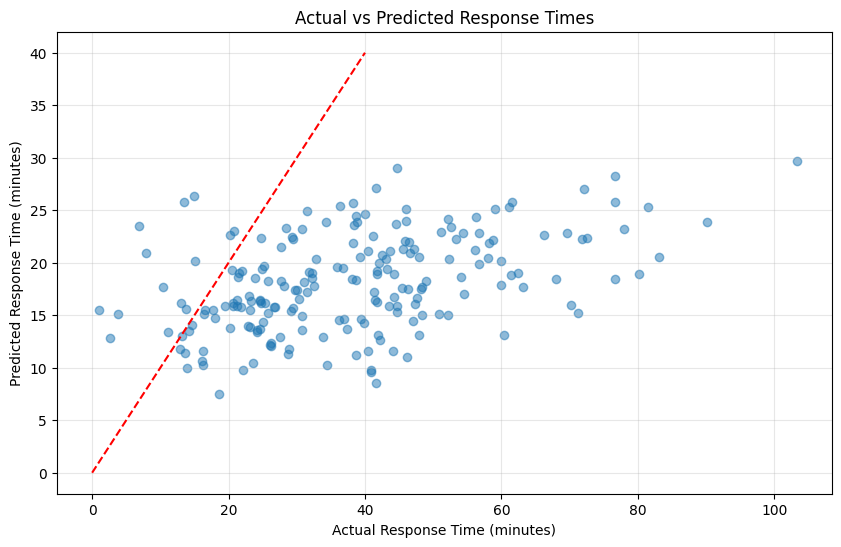

In [ ]:
# Make predictions with the model against our synthetic data
predict_synthetic_query = f"""
SELECT
  *
FROM
  ML.PREDICT(MODEL `{project_id}.{dataset_id}.response_time_prediction_model`,
    (
    SELECT
      call_type,
      location,
      weather_condition,
      day_of_week,
      time_of_day,
      traffic_level,
      distance_to_station,
      units_available,
      response_time as actual_response_time
    FROM
      `{project_id}.{dataset_id}.{table_id}`
    )
  )
"""

# Run the prediction query
predict_job = client.query(predict_synthetic_query)
try:
    predict_results = predict_job.result()

    # Create a DataFrame from the results
    predictions_df = []
    for row in predict_results:
        predictions_df.append({
            'call_type': row.call_type,
            'location': row.location,
            'weather_condition': row.weather_condition,
            'day_of_week': row.day_of_week,
            'time_of_day': row.time_of_day,
            'traffic_level': row.traffic_level,
            'distance_to_station': row.distance_to_station,
            'units_available': row.units_available,
            'actual_response_time': row.actual_response_time,
            'predicted_response_time': row.predicted_response_time
        })

    predictions_df = pd.DataFrame(predictions_df)

    # Calculate prediction errors
    predictions_df['error'] = predictions_df['actual_response_time'] - predictions_df['predicted_response_time']
    predictions_df['abs_error'] = abs(predictions_df['error'])

    # Display results
    print("Prediction results on synthetic data:")
    print(f"Average absolute error: {predictions_df['abs_error'].mean():.2f} minutes")
    print("\nSample predictions:")
    print(predictions_df[['call_type', 'location', 'distance_to_station', 'units_available',
                         'actual_response_time', 'predicted_response_time', 'error']].head(10))

    # Create visualization of actual vs predicted
    try:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        plt.scatter(predictions_df['actual_response_time'], predictions_df['predicted_response_time'], alpha=0.5)
        plt.plot([0, 40], [0, 40], 'r--')  # Perfect prediction line
        plt.xlabel('Actual Response Time (minutes)')
        plt.ylabel('Predicted Response Time (minutes)')
        plt.title('Actual vs Predicted Response Times')
        plt.grid(True, alpha=0.3)
        plt.show()
    except Exception as viz_error:
        print(f"Could not create visualization: {viz_error}")

except Exception as e:
    print(f"Error making predictions: {e}")
